# Model exploration

In [159]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
import shap
import mlflow

In [39]:
# parameters
seed = 42
test_size=0.3

In [32]:
df_raw = pd.read_feather("../../data/processed/data-set.ftr")

In [121]:
df_raw.head()

,subscriber,income,age,var1,gender,house_type,lastVisit,product02,house_type_bin,gender_bin,lastVisit_dt,lastVisit_year,lastVisit_month,lastVisit_days,product02_bin,income_imputed,age_imputed,var1_imputed,house_type_imputed,house_type_bin_imputed
0,1,118239.80,74.32310,1.216512,f,OWNER,1/1/2012 2:09,Nee,1.0,0.0,2012-01-01 02:09:00,2012,1,1,0,False,False,False,False,False
1,2,348760.40,45.86138,3.672188,f,OWNER,1/1/2012 14:03,Ja,1.0,0.0,2012-01-01 14:03:00,2012,1,1,1,False,False,False,False,False
2,3,96111.34,43.18818,0.578956,f,OWNER,1/1/2012 23:58,Nee,1.0,0.0,2012-01-01 23:58:00,2012,1,1,0,False,False,False,False,False
3,4,73818.17,43.32941,-0.129441,m,RENTAL,1/2/2012 3:51,Ja,0.0,1.0,2012-01-02 03:51:00,2012,1,2,1,False,False,False,False,False
4,5,36469.51,34.87954,-0.127675,m,RENTAL,1/2/2012 13:50,Nee,0.0,1.0,2012-01-02 13:50:00,2012,1,2,0,False,False,False,False,False


Thoughts:
- Logistic regression makes the best start for binary classification problems
- Decision trees or Random forest would make a good second/third option
- Should try Gradient Boosting algorithm as well

In [88]:
features = ['income', 'income_imputed', 'age', 'age_imputed', 'var1', 'var1_imputed', 'house_type_bin_imputed', 'lastVisit_year', "lastVisit_days", "product02_bin"]
features_no_impute = ['income', 'age', 'var1', 'lastVisit_year', "lastVisit_days", "product02_bin"]

In [99]:
df = df_raw[features]
df_no_impute = df_raw[features_no_impute]

Train test split

In [127]:
def split_df(df):
    X = df.drop('product02_bin', axis=1)
    y = df['product02_bin']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    return X_train, X_test, y_train, y_test, X, y

X_train, X_test, y_train, y_test, X, y = split_df(df)
X_train_no_impute, X_test_no_impute, y_train_no_impute, y_test_no_impute, X_no_impute, y_no_impute = split_df(df_no_impute)


In [128]:
X100 = shap.utils.sample(X, 100)
X100_no_impute = shap.utils.sample(X_no_impute, 100)

### scoring

In [102]:
def scoring(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # True pos + True negatives / all predictions
    print(f'Accuracy: {accuracy}')
    
    # True pos of all positive predicted
    print(f'Precision: {precision}')
    
    # True pos of true pos + false neg
    print(f'Recall: {recall}')
    
    # weighted accuracy and precision
    print(f'F1-Score: {f1}')
    

### Model

#### Logistic

In [130]:
def log_pred(X_train, X_test, y_train, y_test):
    # Initialize the logistic regression model
    log_model = LogisticRegression(random_state=seed)
    log_model.fit(X_train, y_train)
    log_y_pred = log_model.predict(X_test)
    
    scoring(y_test, log_y_pred)
    return log_model

log_model = log_pred(X_train, X_test, y_train, y_test)
print("\n")
log_model = log_pred(X_train_no_impute, X_test_no_impute, y_train_no_impute, y_test_no_impute)


Accuracy: 0.6473839351510685
Precision: 0.6136363636363636
Recall: 0.38675022381378693
F1-Score: 0.47446457990115326


Accuracy: 0.6473839351510685
Precision: 0.6136363636363636
Recall: 0.38675022381378693
F1-Score: 0.47446457990115326


In [ ]:
explainer = shap.explainers.Permutation(log_model.predict_proba, X_no_impute)
shap_values  = explainer(X100_no_impute)

In [139]:
all(X_no_impute.columns == X100_no_impute.columns)

True

In [140]:
shap.plots.bar(shap_values)

IndexError: list index out of range

In [75]:
explainer = shap.Explainer(model.predict, X)
shap_values = explainer.shap_values(X)

AttributeError: 'ExactExplainer' object has no attribute 'shap_values'

##### Decision Tree

In [58]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_y_pred = dt_model.predict(X_test)
scoring(y_test, dt_y_pred)


Accuracy: 0.6168017686072218
Precision: 0.5325443786982249
Recall: 0.5640107430617726
F1-Score: 0.5478260869565217


##### Random forest

In [56]:
# Random Forest
rf_model = RandomForestClassifier(random_state=seed)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
scoring(y_test, rf_y_pred)


Accuracy: 0.681650700073692
Precision: 0.6640726329442282
Recall: 0.4583706356311549
F1-Score: 0.5423728813559322


##### XGBoost

In [68]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

scoring(y_test, xgb_y_pred)

Accuracy: 0.6735445836403832
Precision: 0.6431226765799256
Recall: 0.4646374216651746
F1-Score: 0.5395010395010394


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

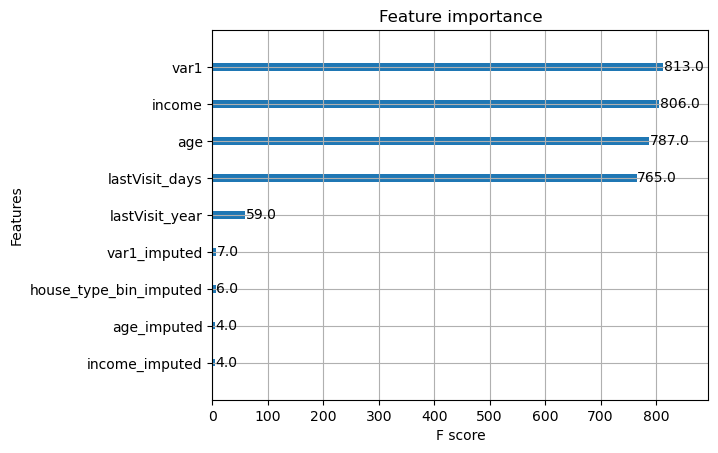

In [145]:
plot_importance(xgb_model)

Accuracy: 0.6746499631540163
Precision: 0.6437346437346437
Recall: 0.4691136974037601
F1-Score: 0.5427239772138789


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

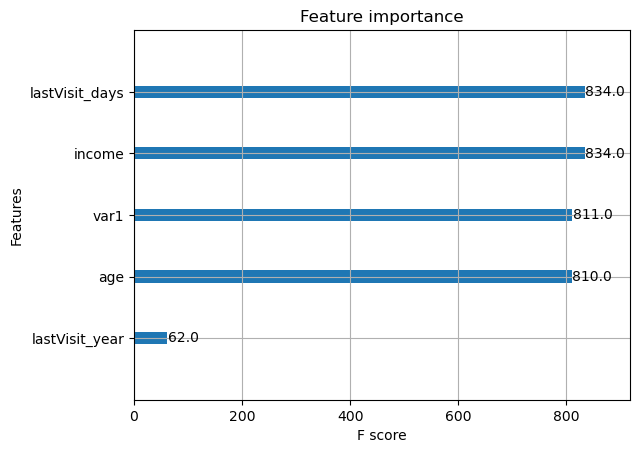

In [146]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_no_impute, y_train_no_impute)
xgb_y_pred = xgb_model.predict(X_test_no_impute)

scoring(y_test_no_impute, xgb_y_pred)
plot_importance(xgb_model)


In [147]:
df_investigate = X_test_no_impute.copy(deep=True)
df_investigate["target"] = y_test_no_impute 
df_investigate["target_predicted"] = xgb_y_pred

In [150]:
df_investigate_wrong_pred = df_investigate[df_investigate.target!=df_investigate.target_predicted]

In [151]:
df_investigate_wrong_pred.head()

,income,age,var1,lastVisit_year,lastVisit_days,target,target_predicted
94,6502.621529,19.237016,1.518227,2012,19,0,1
4910,6180.768357,26.357011,-0.207179,2014,926,1,0
881,5021.752000,24.352310,-0.093795,2012,160,1,0
3722,121481.556200,56.231965,-0.576665,2013,709,1,0
2573,33005.348680,21.215166,1.842484,2013,484,1,0


In [154]:
df_investigate_wrong_pred.shape

(883, 7)

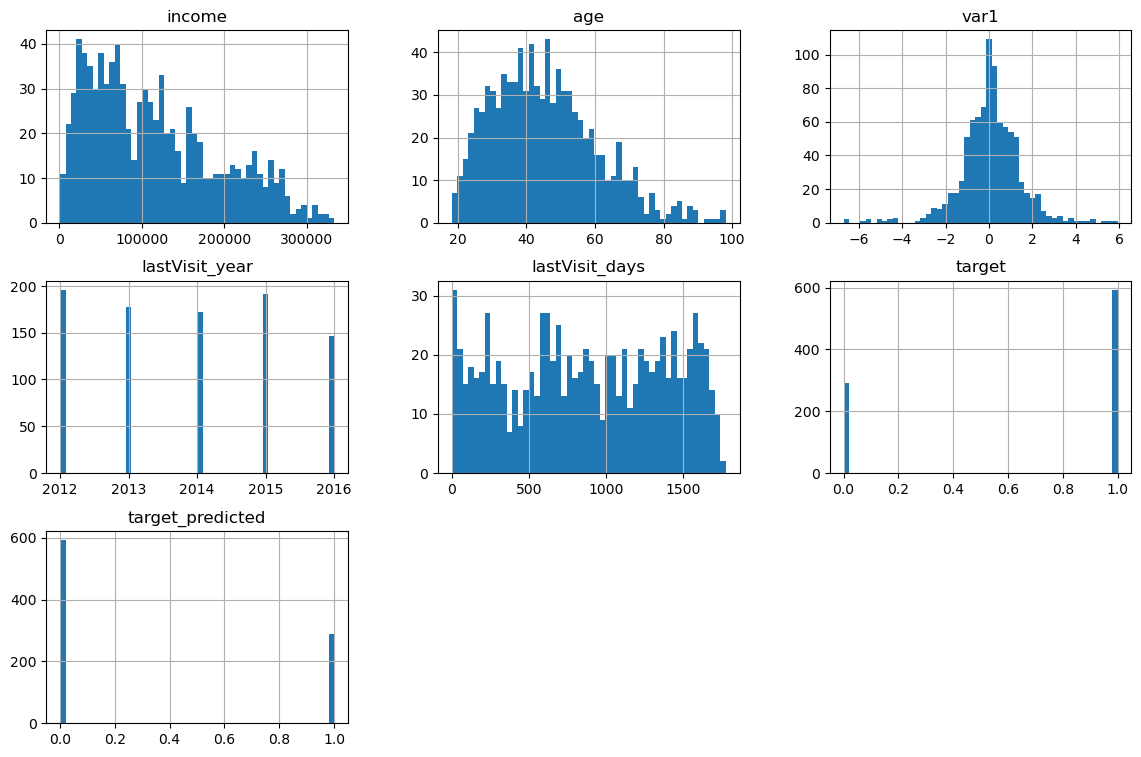

In [158]:
df_investigate_wrong_pred.hist(bins=50, figsize=(14,9));

### preliminary conclusions/thoughts
- 0 is more predicted than it actually is, might need to do resampling or another balancing method
- More thorough investigation in why the predictions are false.
- Remove lastVisit_year
- Low incomes are indeed badly predicted, might need to use a lowerbound